In [1]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
# df.head()

In [2]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10.Ticker

5      BTC-USD
16        META
7      EQQQ.DE
8      ETH-USD
3      BNB-USD
15       MC.PA
6     DOGE-USD
12     IWDE.MI
21        RACE
22        TSLA
Name: Ticker, dtype: object

In [3]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# # some Ticker should be adjusted for the data source
# port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [4]:
port_list

['BTC-USD',
 'META',
 'EQQQ.DE',
 'ETH-USD',
 'BNB-USD',
 'MC.PA',
 'DOGE-USD',
 'IWDE.MI',
 'RACE',
 'TSLA']

In [5]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [6]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# IMPORTANT: Convert index to datetime for proper date handling
df_stocks.index = pd.to_datetime(df_stocks.index)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

print(f"Index type: {type(df_stocks.index[0])}")
print(f"Date range: {df_stocks.index.min()} to {df_stocks.index.max()}")

df_stocks.head()

Index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Date range: 2020-01-02 00:00:00 to 2025-10-07 00:00:00


Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.761078,127.410179,57.299999,383.397308,208.494690,161.780365,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.288239,134.171707,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.288239,135.069366,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.288239,136.276779,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.288239,144.304153,57.060001,379.738556,211.297440,159.226593,30.102667


In [7]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()

# Verify datetime index
print(f"Returns index type: {type(returns.index[0])}")
print(f"Returns shape: {returns.shape}")
print(f"Returns date range: {returns.index.min()} to {returns.index.max()}")

# Ensure returns index is datetime
if not isinstance(returns.index, pd.DatetimeIndex):
    print("Converting returns index to datetime...")
    returns.index = pd.to_datetime(returns.index)

Y = returns.copy()
Y.head()

Returns index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Returns shape: (2105, 10)
Returns date range: 2020-01-03 00:00:00 to 2025-10-07 00:00:00


Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-03,0.048625,0.051452,0.067695,0.002808,0.053069,-0.002443,-0.000119,-0.005291,-0.010563,0.029633
2020-01-04,0.016915,0.008955,0.044755,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.015802,0.000089,0.079429,0.000000,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.060009,0.048291,0.018189,0.000000,0.058905,-0.001749,-0.009425,0.018834,-0.005278,0.019255
2020-01-07,0.003439,0.050774,-0.012180,0.009539,-0.005268,0.003680,0.002047,0.002163,-0.003799,0.038801


Calculating the portfolio

In [8]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

# Use multiple solvers as fallback (MOSEK might not be available)
port.solvers = ['CLARABEL', 'ECOS', 'SCS', 'OSQP'] # More reliable solvers
port.alpha = 0.05 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' # Risk measure used, this time will be EDaR (Entropic Drawdown at Risk)
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

try:
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    if w is not None:
        print("Optimization successful!")
        display(w.T)
    else:
        print("Optimization failed. Trying with simpler risk measure...")
        # Fallback to Mean Variance optimization if EDaR fails
        w = port.optimization(model=model, rm='MV', obj=obj, rf=rf, l=l, hist=hist)
        if w is not None:
            print("Fallback optimization (Mean Variance) successful!")
            display(w.T)
        else:
            print("Both optimizations failed. Please check your data and parameters.")
except Exception as e:
    print(f"Optimization error: {e}")
    print("Trying fallback optimization with Mean Variance...")
    try:
        w = port.optimization(model=model, rm='MV', obj=obj, rf=rf, l=l, hist=hist)
        if w is not None:
            print("Fallback optimization successful!")
            display(w.T)
        else:
            print("All optimization attempts failed.")
    except Exception as e2:
        print(f"Fallback optimization also failed: {e2}")

Optimization successful!


,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
weights,0.001916,1.607715e-10,0.604428,1.445435e-09,1.925086e-10,8.144258e-10,2.951676e-09,2.103059e-10,8.835264e-10,0.393656


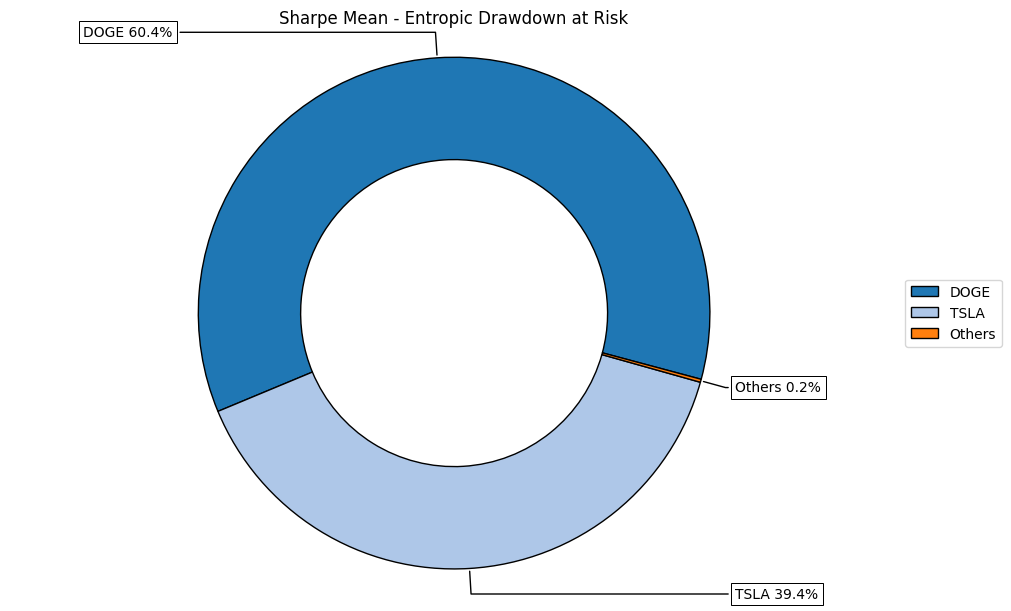

In [9]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean - Entropic Drawdown at Risk', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

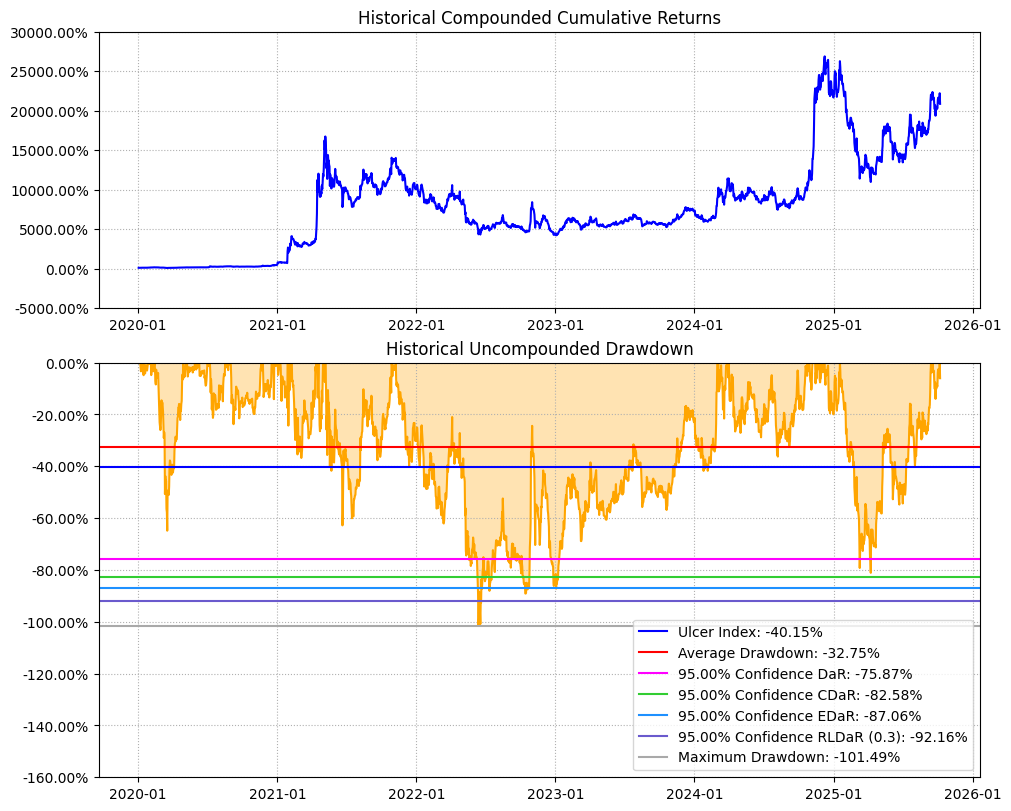

In [10]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

In [ ]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

In [ ]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [ ]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

In [ ]:
# Plotting portfolio composition
ax = rp.plot_pie(w=w_rp, title='Risk Parity EDaR', others=0.05, nrow=25, cmap = "tab20",
                 height=8, width=12, ax=None)

In [ ]:
# Plotting Risk Composition
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=12, ax=None)

In [ ]:
# Plotting Risk Composition
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=12, ax=None)